In [1]:
!pip install tensorflow==2.9.1

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 444.1/444.1 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 438.7/438.7 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 42.6/42.6 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 2.9 MB/s eta 0:00:00
     -------------------------------------- 895.7/895.7 kB 3.5 MB/s eta 0:00:00
     -------------------------------------- 781.3/781.3 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorflow-es

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
tensorflow-intel 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.9.0 which is incompatible.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-intel 2.12.0 requires tensorboard<2.13,>=2.12, but you have tensorboard 2.9.1 which is incomp

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Data Preprocessing

In [5]:
# Generate data paths with labels
data_dir = 'D:\DataSet\Prepared Data\Train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
df

,filepaths,labels
0,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
1,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
2,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
3,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
4,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
...,...,...
80393,D:\DataSet\Prepared Data\Train\Open Eyes\s0037...,Open Eyes
80394,D:\DataSet\Prepared Data\Train\Open Eyes\s0037...,Open Eyes
80395,D:\DataSet\Prepared Data\Train\Open Eyes\s0037...,Open Eyes
80396,D:\DataSet\Prepared Data\Train\Open Eyes\s0037...,Open Eyes


# Split DataFrame into train, valid and test

In [7]:
# train dataframe
train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# Read test data and store it in dataframe

In [8]:
# Generate data paths with labels
data_dir = 'D:\DataSet\Prepared Data\Test'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [9]:
df

,filepaths,labels
0,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
1,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
2,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
3,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
4,D:\DataSet\Prepared Data\Train\Close Eyes\s000...,Close Eyes
...,...,...
80393,D:\DataSet\Prepared Data\Train\Open Eyes\s0037...,Open Eyes
80394,D:\DataSet\Prepared Data\Train\Open Eyes\s0037...,Open Eyes
80395,D:\DataSet\Prepared Data\Train\Open Eyes\s0037...,Open Eyes
80396,D:\DataSet\Prepared Data\Train\Open Eyes\s0037...,Open Eyes


# Create Image Data Generator

In [10]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 64318 validated image filenames belonging to 2 classes.
Found 16080 validated image filenames belonging to 2 classes.
Found 4500 validated image filenames belonging to 2 classes.


# Show Sample Train Data

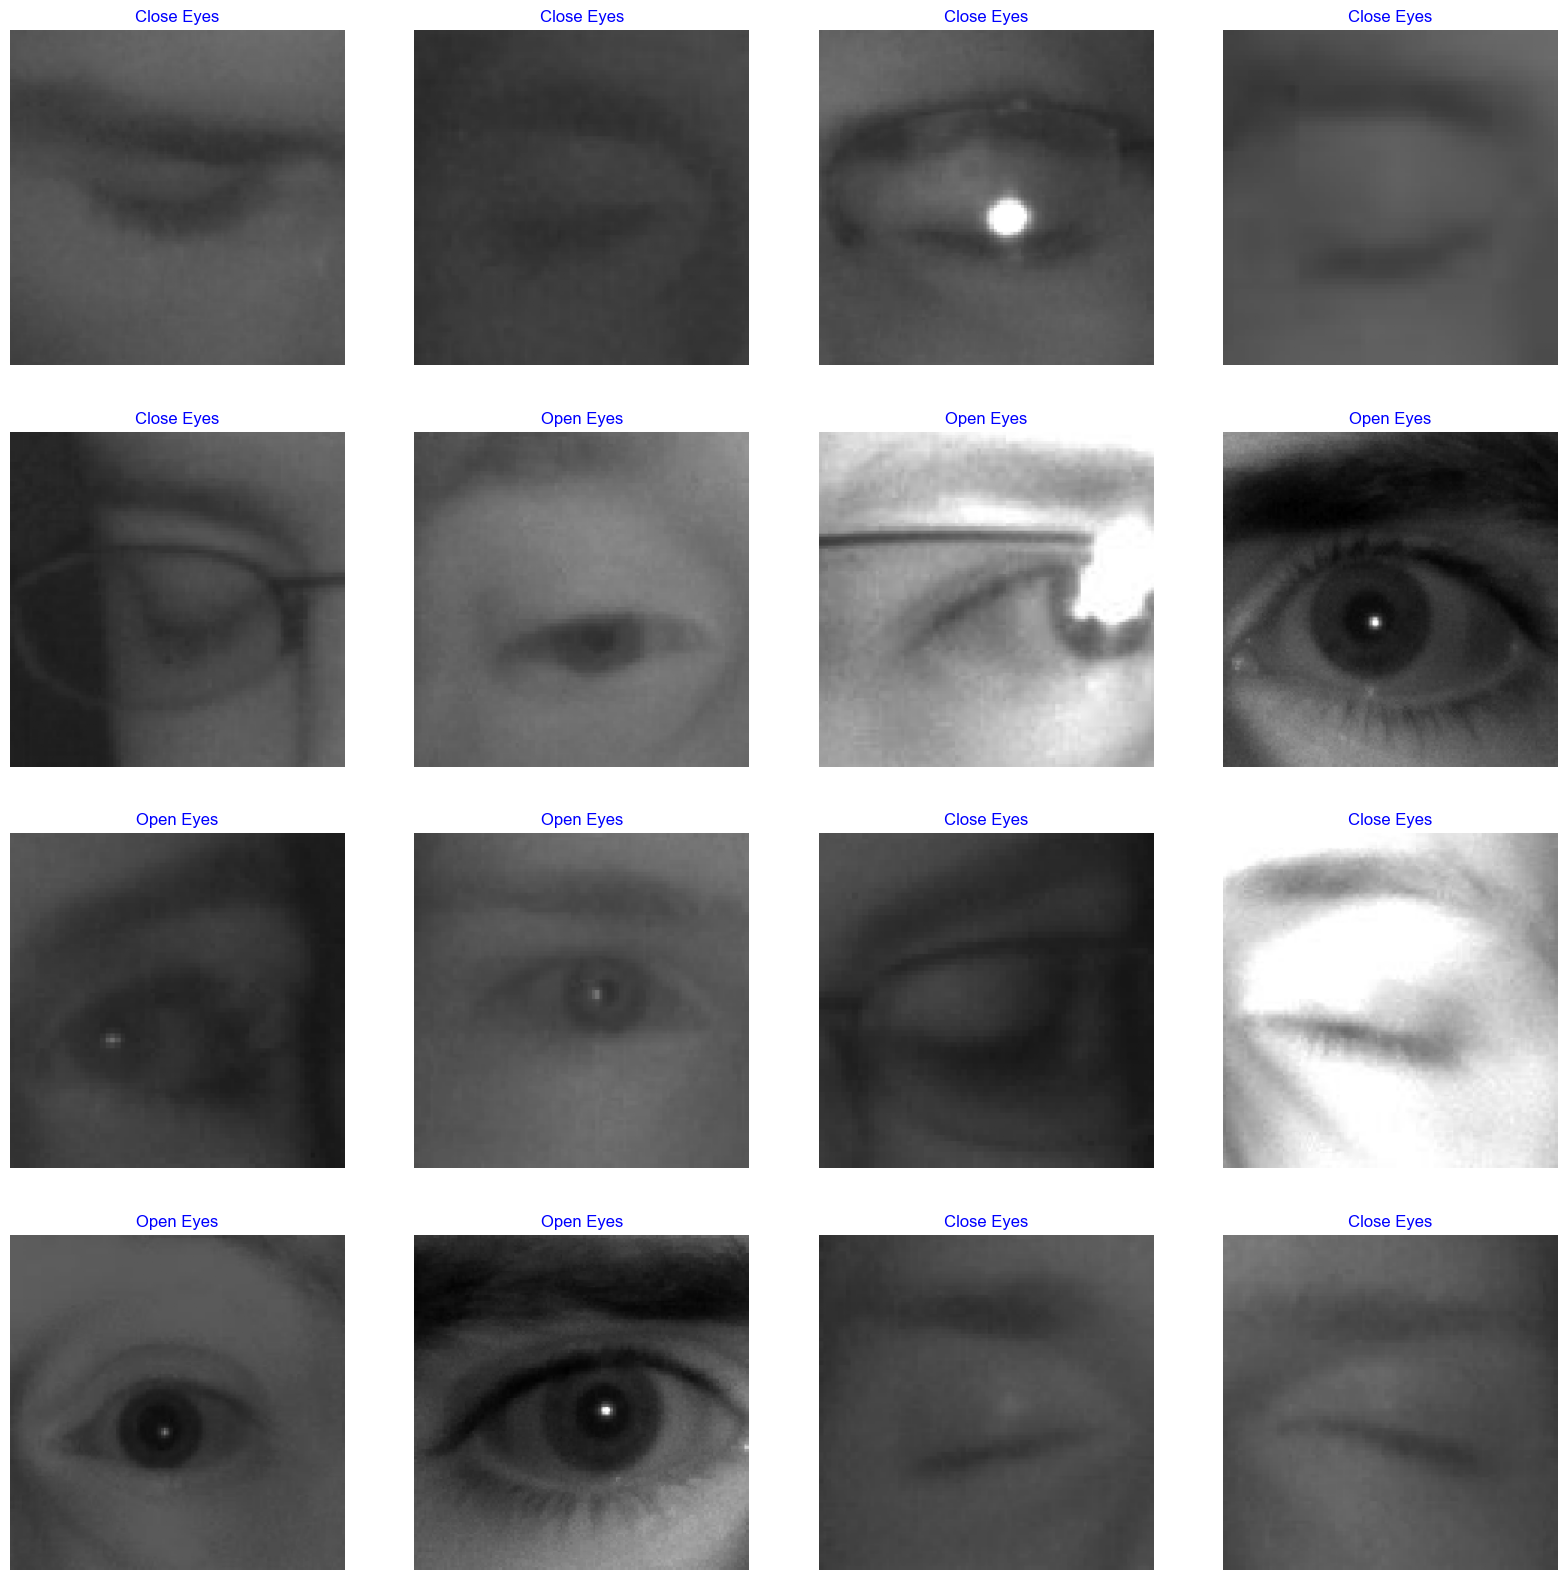

In [11]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

Generic Model Creation

In [12]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 14s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-

# Training Model

In [16]:
batch_size = 16   # set batch size for training
epochs = 1   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

4020/4020 [==============================] - 11342s 3s/step - loss: 0.0945 - accuracy: 0.9897 - val_loss: 0.0739 - val_accuracy: 0.9904


# Display Model Performance

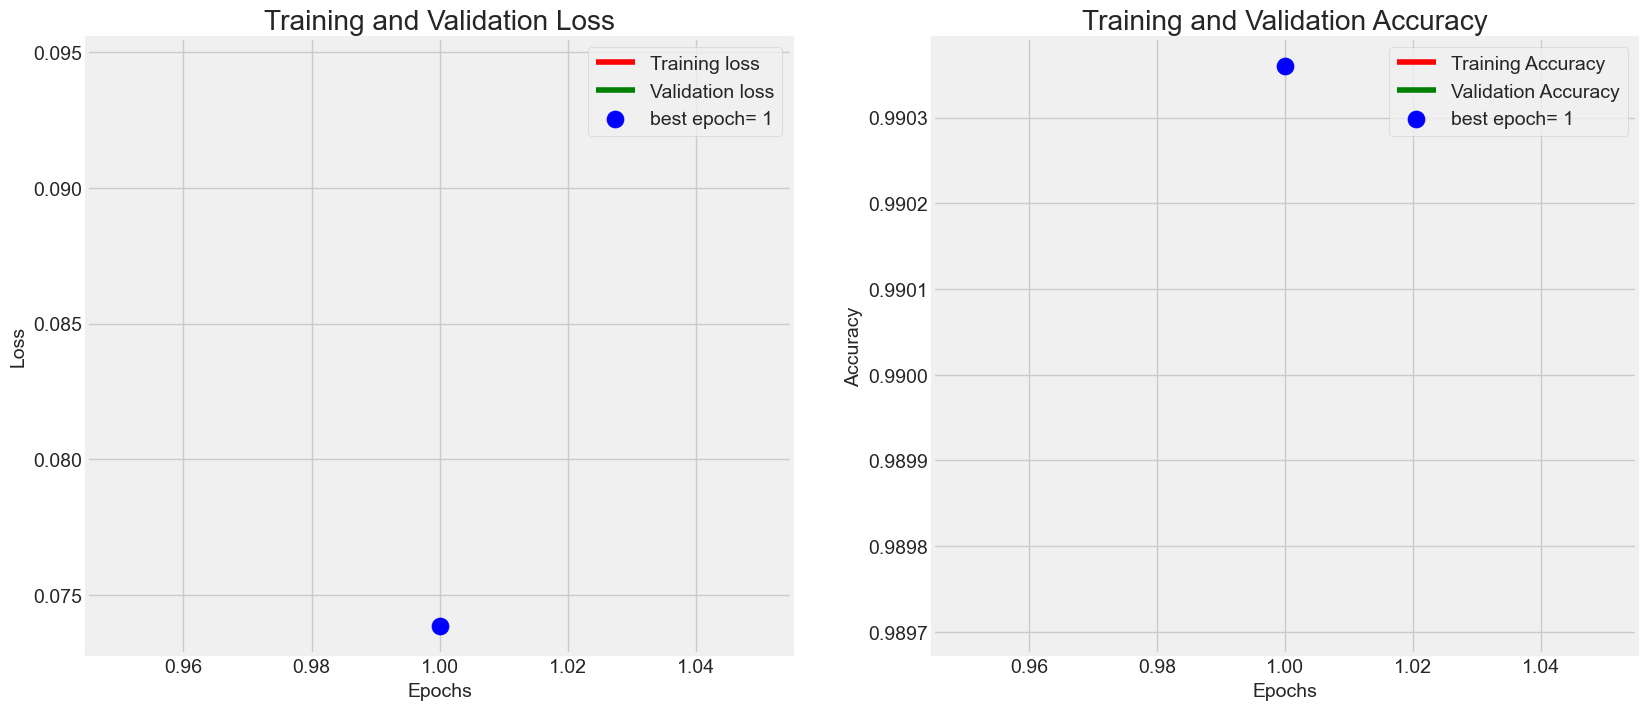

In [17]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

60/60 [==============================] - 140s 2s/step - loss: 0.3115 - accuracy: 0.9360
Train Loss:  0.0630616620182991
Train Accuracy:  0.9937499761581421
--------------------
Validation Loss:  0.07095212489366531
Validation Accuracy:  0.9927083253860474
--------------------
Test Loss:  0.3114854693412781
Test Accuracy:  0.9359999895095825


# Get Prediction

In [19]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Confusion Matrics and Classification Report

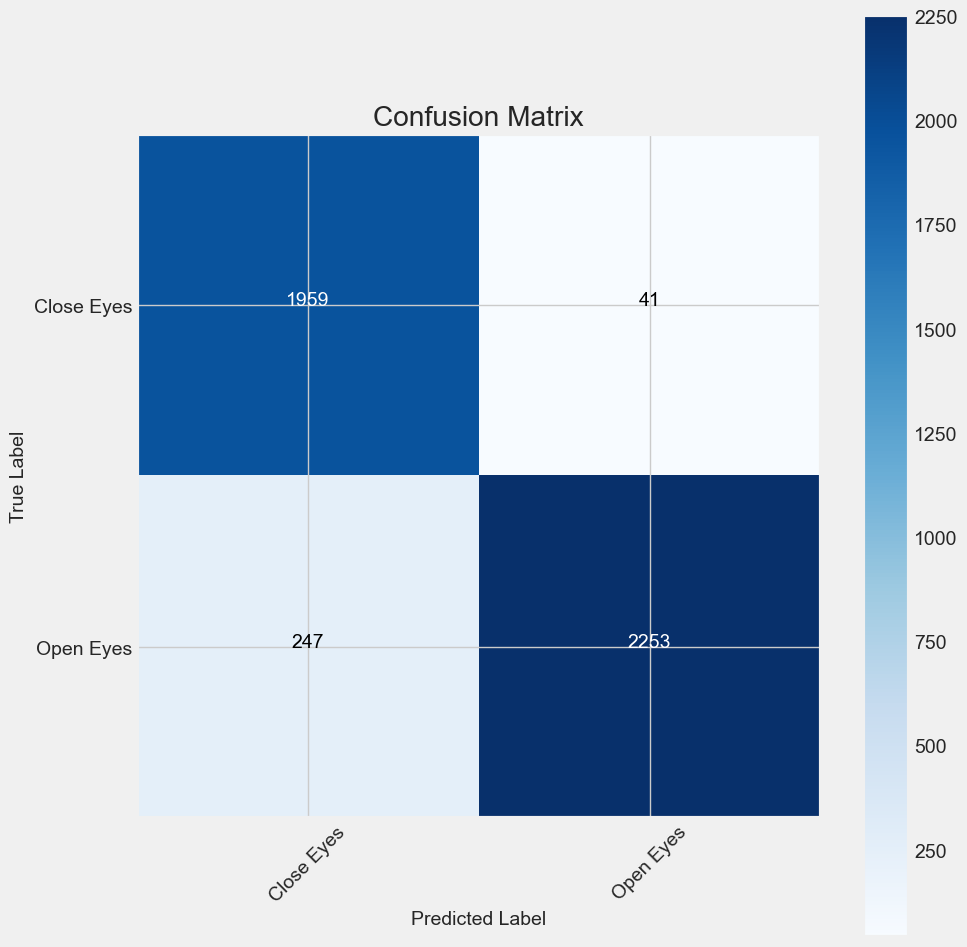

In [20]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [21]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

  Close Eyes       0.89      0.98      0.93      2000
   Open Eyes       0.98      0.90      0.94      2500

    accuracy                           0.94      4500
   macro avg       0.94      0.94      0.94      4500
weighted avg       0.94      0.94      0.94      4500



Saving Model

In [22]:
model_name = model.input_names[0][:-6]
subject = 'EyeDetection'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb0-EyeDetection-93.60.h5
weights were saved as efficientnetb0-EyeDetection-weights.h5
